In [1]:
import tensorflow as tf
import datetime
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import gensim

In [2]:
word_index = tf.keras.datasets.imdb.get_word_index()
word_index = {y:x for x,y in word_index.items()}
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    index_from=0, num_words=2000)
# x_train, y_train = x_train[:5000], y_train[:5000] # TODO: 1000
# x_test, y_test = x_test[:2000], y_test[:2000]

In [3]:
model_path = 'model.bin'
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, 
                                                                 binary=True)

In [4]:
def test_params_lstm(batch_size, learning_coef, epochs, cost_func, optimizer, 
                     use_w2v, max_len, embedding_length, h_size,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    num_words = 2000 # max(x_train.max())
    model = LSTMModel(use_w2v=use_w2v, h_size=h_size, max_len=max_len, 
                      num_words=num_words,
              embedding_length=embedding_length)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()


def test_params_rnn(batch_size, learning_coef, epochs, cost_func, optimizer, 
                     use_w2v, max_len, embedding_length, h_size,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    num_words = 2000 # max(x_train.max())
    model = RNNMModel(use_w2v=use_w2v, max_len=max_len, num_words=num_words,
              embedding_length=embedding_length, h_size=h_size)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [5]:
def vectorize_texts(x_train):
    embeddings = []
    for text in x_train:
        text_vectors = []
        for word in text:
            word = int(word)
            if word in word_index:
                word = word_index[word]
                word = word.lower()
                if word in word2vec_model:
                    text_vectors.append(word2vec_model[word])
                else:
                    text_vectors.append(np.array([0]*300))
            else:
                text_vectors.append(np.array([0]*300))
        embeddings.append(text_vectors)
    return tf.convert_to_tensor(embeddings)

In [6]:
class LSTMModel(tf.keras.Model):
    def __init__(self, h_size=8, use_w2v=False, max_len=500, 
                 embedding_length=100, num_words=2000):
        super(LSTMModel, self).__init__()
        
        self.num_words = num_words
        self.h_size = h_size
        self.use_w2v = use_w2v
        self.max_len = max_len
        self.embedding_length = embedding_length
        if not self.use_w2v:
            self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_length)

        self.w_f = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_length), 
                                   initializer='truncated_normal', trainable=True)
        self.b_f = self.add_weight(shape=(self.h_size, 1), 
                                   initializer='truncated_normal', trainable=True)
        
        self.w_i = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_length), 
                                   initializer='truncated_normal', trainable=True)
        self.b_i = self.add_weight(shape=(self.h_size, 1), 
                                   initializer='truncated_normal', trainable=True)
        
        self.w_c = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_length), 
                                   initializer='truncated_normal', trainable=True)
        self.b_c = self.add_weight(shape=(self.h_size, 1), 
                                   initializer='truncated_normal', trainable=True)
        
        self.w_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_length), 
                                   initializer='truncated_normal', trainable=True)
        self.b_o = self.add_weight(shape=(self.h_size, 1), 
                                   initializer='truncated_normal', trainable=True)

        self.dense = tf.keras.layers.Dense(units=2, activation='softmax')

    def __call__(self, x, training=False):
        h = tf.zeros(shape=(self.h_size, len(x)))
        c = tf.zeros(shape=(self.h_size, len(x)))
        
        if not self.use_w2v:
            x = self.embedding_layer(x)
        
        for i in range(self.max_len):  # x.shape[1]
            h, c = self.lstm_cell(x[:, i], h, c)
        
        x = self.dense(tf.transpose(h))

        return x
    
    def lstm_cell(self, x_t, h_prev, c_prev):
        x_t = tf.transpose(x_t)

        f = tf.sigmoid(tf.matmul(self.w_f, tf.concat([x_t, h_prev], 0)) + self.b_f)
        i = tf.sigmoid(tf.matmul(self.w_i, tf.concat([x_t, h_prev], 0)) + self.b_i)
        z = tf.tanh(tf.matmul(self.w_c, tf.concat([x_t, h_prev], 0)) + self.b_c)
        c = f * c_prev + i * z
        
        o = tf.sigmoid(tf.matmul(self.w_o, tf.concat([x_t, h_prev], 0)) + self.b_o)
        h = o * tf.tanh(c)
        
        return h, c

    def fit(self, **kwargs):
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.epoch_fscore = []
        self.epoch_time = []

        x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer = self._get_params(**kwargs)
        
        weight_decay = kwargs.get('weight_decay', None)
        if weight_decay is not None:
            optimizer = optimizer(weight_decay=weight_decay, learning_rate=learning_coef)
        else:
            optimizer = optimizer(learning_rate=learning_coef)
        train_dataset = self._extract_train_dataset(x_train, y_train, batch_size)

        for epoch in range(epochs):
            start = datetime.datetime.now()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()
            
            print("epoch: ", epoch)
            i = 0
            for x, y in train_dataset:
                # print(i)
                i += 1
                
                if self.use_w2v:
                    x = vectorize_texts(x)
                # x = tf.keras.utils.to_categorical(x, num_classes=self.num_words)
                
                with tf.GradientTape() as tape:
                    logits = self.__call__(x, training=True)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)

            end = datetime.datetime.now()
            diff = end - start
            self.epoch_time.append(diff.total_seconds())

            self.epoch_accuracy.append(epoch_acc.result().numpy())

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))

    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        x_dataset = self._extract_test_dataset(x, batch_size=100)
        prediction = []
        for x in x_dataset:
            # x = tf.keras.utils.to_categorical(x, num_classes=self.num_words)
            if self.use_w2v:
                x = vectorize_texts(x)
            logits = self.__call__(x)
            prediction.extend(tf.argmax(logits, axis=1, output_type=tf.int32))
        return prediction

    def _extract_train_dataset(self, x_train, y_train, batch_size):
        y_train = tf.dtypes.cast(y_train, tf.float32)
        x_train = tf.keras.preprocessing.sequence.pad_sequences(
                x_train, padding='post', maxlen=self.max_len)
            
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=25000).batch(batch_size=batch_size)
        return train_dataset

    def _extract_test_dataset(self, x_train, batch_size):
        x_train = tf.keras.preprocessing.sequence.pad_sequences(
                x_train, padding='post', maxlen=self.max_len)
            
        train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
        train_dataset = train_dataset.batch(batch_size=batch_size)
        return train_dataset

    def _get_params(self, **kwargs):
        x_train = kwargs.get('x', None)
        y_train = kwargs.get('y', None)
        epochs = kwargs.get('epochs', 10)
        batch_size = kwargs.get('batch_size', 100)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        learning_coef = kwargs.get('learning_coef', 0.001)
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam)
        return x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer


In [12]:
class RNNMModel(LSTMModel):
    def __init__(self, h_size=8, use_w2v=False, max_len=500, 
                 embedding_length=100, num_words=2000):
        super(LSTMModel, self).__init__()
        
        self.num_words = num_words
        self.h_size = h_size
        self.use_w2v = use_w2v
        self.max_len = max_len
        self.embedding_length = embedding_length
        if not self.use_w2v:
            self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_length)
        
        self.w_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_length), 
                                   initializer='truncated_normal', trainable=True)
        self.b_o = self.add_weight(shape=(self.h_size, 1), 
                                   initializer='truncated_normal', trainable=True)

        self.dense = tf.keras.layers.Dense(units=2, activation='softmax')

    def __call__(self, x, training=False):
        h = tf.zeros(shape=(self.h_size, len(x)))
        
        if not self.use_w2v:
            x = self.embedding_layer(x)

        for i in range(x.shape[1]):
            h = self.rnn_cell(x[:, i], h)
        
        x = self.dense(tf.transpose(h))

        return x
    
    def rnn_cell(self, x_t, h_prev):
        x_t = tf.transpose(x_t)
        c = tf.tanh(tf.matmul(self.w_o, tf.concat([x_t, h_prev], 0)) + self.b_o)
        return c
    

In [9]:
%%time

batch_size = 100
learning_coef = 0.001
epochs = 4
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam
max_len = 64
h_size = 8
use_w2v, embedding_length = (True, 300) # (False, 100)


results = test_params_lstm(batch_size=batch_size, learning_coef=learning_coef, 
                           epochs=epochs, cost_func=cost_func, 
                           optimizer=optimizer, use_w2v=use_w2v, 
                           max_len=max_len, embedding_length=embedding_length,
                           h_size=h_size)
model, acc, f1, loss = results

res_df = pd.DataFrame(columns=['model', 'batch_size', 'learning_coef', 'epochs', 
                               'cost_func', 'optimizer', 'use_w2v', 'max_len',
                               'embedding_len', 'h_size', 'acc', 'f1', 'loss',
                               'time'])
res_df = res_df.append({'model': 'LSTM', 'batch_size': batch_size, 
                        'learning_coef': learning_coef,
                        'epochs': epochs, 'cost_func': type(cost_func).__name__, 
                        'optimizer': optimizer.__name__, 'use_w2v': use_w2v,
                        'max_len': max_len, 'embedding_len': embedding_length,
                        'h_size': h_size, 'acc': acc, 'f1': f1, 'loss': loss, 
                        'time': sum(model.epoch_time)}, 
                       ignore_index=True)

with open('results.csv', 'a') as f:
    res_df.to_csv(f, header=False)

print('Time: {}'.format(sum(model.epoch_time)))

Started fitting
epoch:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 00: Loss: 0.688, Accuracy: 52.680%
epoch:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 01: Loss: 0.683, Accuracy: 57.080%
epoch:  2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 02: Loss: 0.574, Accuracy: 63.720%
epoch:  3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 03: Loss: 0.550, Accuracy: 71.080%
Time: 347.780646
CPU times: user 6min 6s, sys: 2.25 s, total: 6min 8s
Wall time: 6min 11s


**Test hyperparameters**

In [11]:
%%time

batch_size = 100
learning_coef = 0.001
epochs = 3
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam
max_len = 64
h_size = 8
use_w2v, embedding_length = (True, 300) # (False, 100)

experiments_epochs = [4]
experiments_learning_coef = [0.001, 0.005]
experiments_optimizer = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam]
experiments_use_w2v = [(False, 100), (True, 300)]

for use_w2v, embedding_length in experiments_use_w2v:
    for epochs in experiments_epochs:
      for learning_coef in experiments_learning_coef:
        for optimizer in experiments_optimizer:
            results = test_params_lstm(batch_size=batch_size, learning_coef=learning_coef, 
                               epochs=epochs, cost_func=cost_func, 
                               optimizer=optimizer, use_w2v=use_w2v, 
                               max_len=max_len, embedding_length=embedding_length,
                               h_size=h_size)
            model, acc, f1, loss = results
                
            res_df = pd.DataFrame(columns=['model', 'batch_size', 'learning_coef', 'epochs', 
                                           'cost_func', 'optimizer', 'use_w2v', 'max_len',
                                           'embedding_len', 'h_size', 'acc', 'f1', 'loss',
                                           'time'])
            res_df = res_df.append({'model': 'LSTM', 'batch_size': batch_size, 
                                    'learning_coef': learning_coef,
                                    'epochs': epochs, 'cost_func': type(cost_func).__name__, 
                                    'optimizer': optimizer.__name__, 'use_w2v': use_w2v,
                                    'max_len': max_len, 'embedding_len': embedding_length,
                                    'h_size': h_size, 'acc': acc, 'f1': f1, 'loss': loss, 
                                    'time': sum(model.epoch_time)}, 
                                   ignore_index=True)
            
            with open('results.csv', 'a') as f:
                res_df.to_csv(f, header=False)
            
            print('Time: {}'.format(sum(model.epoch_time)))

      # results = test_params_rnn(batch_size=batch_size, learning_coef=learning_coef, 
      #                           epochs=epochs, cost_func=cost_func, 
      #                           optimizer=optimizer)
      # model, acc, f1, loss = results
          
      # res_df = pd.DataFrame(columns=['model', 'batch_size', 'learning_coef', 'epochs', 
      #                               'cost_func', 'optimizer', 'acc', 'f1', 'loss', 'time'])
      # res_df = res_df.append({'model': 'RNN', 'batch_size': batch_size, 'learning_coef': learning_coef,
      #                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
      #                         'optimizer': optimizer.__name__, 
      #                         'acc': acc, 'f1': f1, 'loss': loss, 
      #                         'time': sum(model.epoch_time)}, 
      #                       ignore_index=True)

      # print('Time: {}'.format(sum(model.epoch_time)))

      # with open(DATADIR + 'results.csv', 'a') as f:
      #   res_df.to_csv(f, header=False)

Started fitting
epoch:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 00: Loss: 0.694, Accuracy: 49.220%
epoch:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 01: Loss: 0.693, Accuracy: 49.640%
epoch:  2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 02: Loss: 0.694, Accuracy: 49.780%
epoch:  3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 03: Loss: 0.693, Accuracy: 49.640%
Time: 273.26498300000003
Started fitting
epoch:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Epoch 00: Loss: 0.685, Accura

In [12]:
results = pd.read_csv('results.csv')

In [13]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [14]:
results.style.apply(highlight_max, subset=['acc', 'f1']).apply(highlight_min, subset=['loss', 'time'])

,Unnamed: 0,model,batch_size,learning_coef,epochs,cost_func,optimizer,use_w2v,max_len,embedding_len,h_size,acc,f1,loss,time
0,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,SGD,False,500,100,8,0.5235,0.343617,0.69267,1287.46
1,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,Adam,False,500,100,8,0.4795,0.332324,0.689348,1280.7
2,0,LSTM,100,0.005,4,SparseCategoricalCrossentropy,SGD,False,500,100,8,0.477,0.325443,0.693399,1257.11
3,0,LSTM,100,0.005,4,SparseCategoricalCrossentropy,Adam,False,500,100,8,0.533,0.397671,0.649627,1260.61
4,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,SGD,True,500,300,8,0.477,0.323786,0.694076,3913.65
5,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,Adam,True,500,300,8,0.4765,0.322723,0.695206,4229.65
6,0,LSTM,100,0.005,4,SparseCategoricalCrossentropy,SGD,True,500,300,8,0.467,0.333163,0.69352,4209.98
7,0,LSTM,100,0.005,4,SparseCategoricalCrossentropy,Adam,True,500,300,8,0.532,0.409139,0.673416,3970.3
8,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,Adam,True,64,300,8,0.7355,0.733065,0.549632,347.781
9,0,LSTM,100,0.001,4,SparseCategoricalCrossentropy,SGD,False,64,100,8,0.5,0.484757,0.693265,273.265


# Compare LSTM with RNN

In [ ]:
def visualize(model):
    fig, ax = plt.subplots()
    plt.plot(model.epoch_loss)
    ax.set_title('Epoch loss')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_accuracy)
    ax.set_title('Epoch accuracy')
    plt.show()
    plt.clf()


def compare(model_lstm, model_rnn):
    fig, ax = plt.subplots()
    plt.plot(model_lstm.epoch_loss, label='LSTM')
    plt.plot(model_rnn.epoch_loss, label='RNN')
    ax.set_title('Epoch loss')
    plt.legend()
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model_lstm.epoch_accuracy, label='LSTM')
    plt.plot(model_rnn.epoch_accuracy, label='RNN')
    ax.set_title('Epoch accuracy')
    plt.legend()
    plt.show()
    plt.clf()

In [13]:
%%time

batch_size = 100
learning_coef = 0.005
epochs = 5
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam
max_len = 64
h_size = 8
use_w2v, embedding_length = (True, 300) # (False, 100)

experiments_use_w2v = [(False, 100), (True, 300)]
experiments_func = [test_params_rnn, test_params_lstm]

models = []

for use_w2v, embedding_length in experiments_use_w2v:
    for func in experiments_func:
        results = func(batch_size=batch_size, learning_coef=learning_coef, 
                                   epochs=epochs, cost_func=cost_func, 
                                   optimizer=optimizer, use_w2v=use_w2v, 
                                   max_len=max_len, embedding_length=embedding_length,
                                   h_size=h_size)
        
        model, acc, f1, loss = results
        models.append(model)
        
        res_df = pd.DataFrame(columns=['model', 'batch_size', 'learning_coef', 'epochs', 
                                   'cost_func', 'optimizer', 'use_w2v', 'max_len',
                                   'embedding_len', 'h_size', 'acc', 'f1', 'loss',
                                   'time'])
        model_name = 'LSTM' if func == test_params_lstm else 'RNN'
        res_df = res_df.append({'model': model_name, 'batch_size': batch_size, 
                            'learning_coef': learning_coef,
                            'epochs': epochs, 'cost_func': type(cost_func).__name__, 
                            'optimizer': optimizer.__name__, 'use_w2v': use_w2v,
                            'max_len': max_len, 'embedding_len': embedding_length,
                            'h_size': h_size, 'acc': acc, 'f1': f1, 'loss': loss, 
                            'time': sum(model.epoch_time)}, 
                           ignore_index=True)
        
        with open('results.csv', 'a') as f:
            res_df.to_csv(f, header=False)
        
        print('Time: {}'.format(sum(model.epoch_time)))

Started fitting
epoch:  0
Epoch 00: Loss: 0.489, Accuracy: 67.456%
epoch:  1
Epoch 01: Loss: 0.580, Accuracy: 73.352%
epoch:  2
Epoch 02: Loss: 0.670, Accuracy: 65.656%
epoch:  3
Epoch 03: Loss: 0.656, Accuracy: 62.624%
epoch:  4
Epoch 04: Loss: 0.549, Accuracy: 68.192%
Time: 318.30848199999997
Started fitting
epoch:  0
Epoch 00: Loss: 0.391, Accuracy: 73.996%
epoch:  1
Epoch 01: Loss: 0.378, Accuracy: 82.924%
epoch:  2
Epoch 02: Loss: 0.370, Accuracy: 84.920%
epoch:  3
Epoch 03: Loss: 0.321, Accuracy: 86.352%
epoch:  4
Epoch 04: Loss: 0.255, Accuracy: 87.696%
Time: 548.0389359999999
Started fitting
epoch:  0
Epoch 00: Loss: 0.622, Accuracy: 59.016%
epoch:  1
Epoch 01: Loss: 0.687, Accuracy: 68.580%
epoch:  2
Epoch 02: Loss: 0.605, Accuracy: 65.848%
epoch:  3
Epoch 03: Loss: 0.617, Accuracy: 69.620%
epoch:  4
Epoch 04: Loss: 0.550, Accuracy: 67.560%
Time: 1499.5603919999999
Started fitting
epoch:  0
Epoch 00: Loss: 0.455, Accuracy: 66.628%
epoch:  1
Epoch 01: Loss: 0.461, Accuracy: 76.

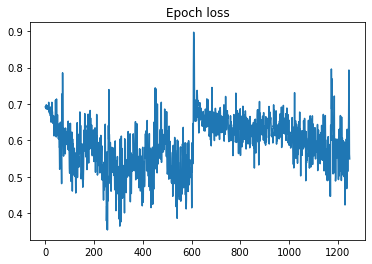

<Figure size 432x288 with 0 Axes>

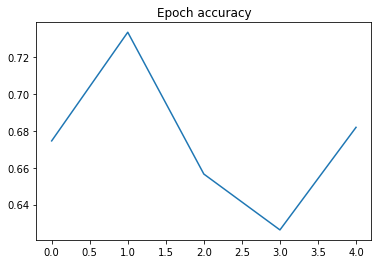

<Figure size 432x288 with 0 Axes>

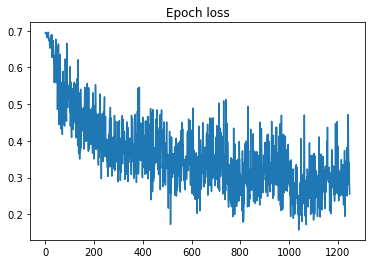

<Figure size 432x288 with 0 Axes>

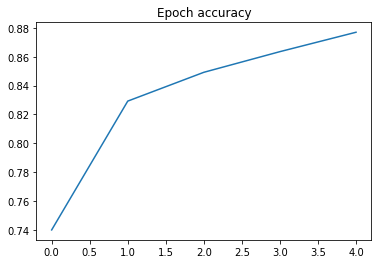

<Figure size 432x288 with 0 Axes>

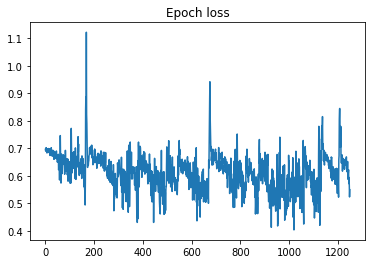

<Figure size 432x288 with 0 Axes>

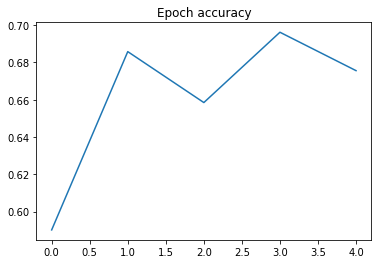

<Figure size 432x288 with 0 Axes>

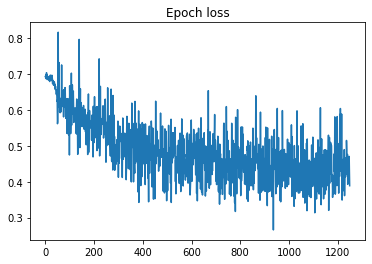

<Figure size 432x288 with 0 Axes>

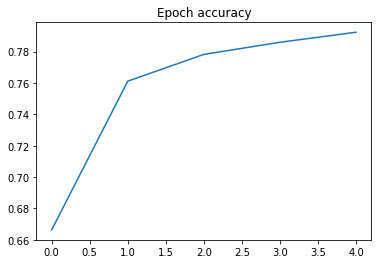

<Figure size 432x288 with 0 Axes>

In [15]:
for model in models:
    visualize(model)
    

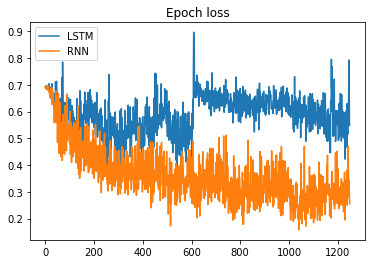

<Figure size 432x288 with 0 Axes>

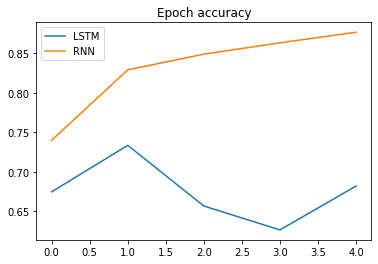

<Figure size 432x288 with 0 Axes>

In [16]:
compare(models[0], models[1])

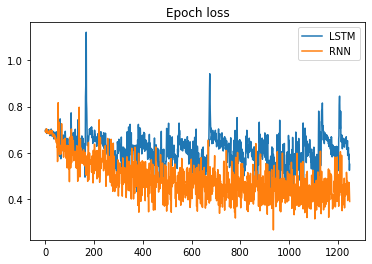

<Figure size 432x288 with 0 Axes>

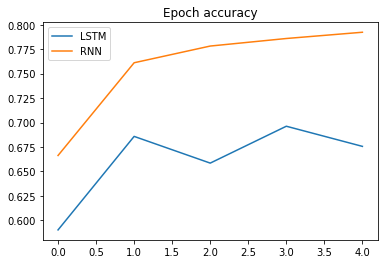

<Figure size 432x288 with 0 Axes>

In [17]:
compare(models[2], models[3])

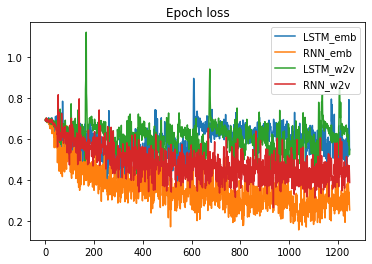

<Figure size 432x288 with 0 Axes>

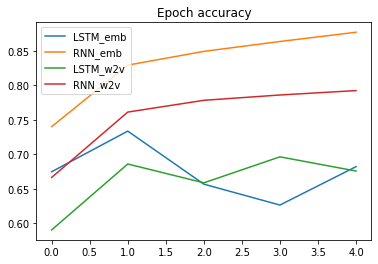

<Figure size 432x288 with 0 Axes>

In [28]:

fig, ax = plt.subplots()
plt.plot(models[0].epoch_loss, label='LSTM_emb')
plt.plot(models[1].epoch_loss, label='RNN_emb')
plt.plot(models[2].epoch_loss, label='LSTM_w2v')
plt.plot(models[3].epoch_loss, label='RNN_w2v')
ax.set_title('Epoch loss')
plt.legend()
plt.show()
plt.clf()

fig, ax = plt.subplots()
plt.plot(models[0].epoch_accuracy, label='LSTM_emb')
plt.plot(models[1].epoch_accuracy, label='RNN_emb')
plt.plot(models[2].epoch_accuracy, label='LSTM_w2v')
plt.plot(models[3].epoch_accuracy, label='RNN_w2v')
ax.set_title('Epoch accuracy')
plt.legend()
plt.show()
plt.clf()

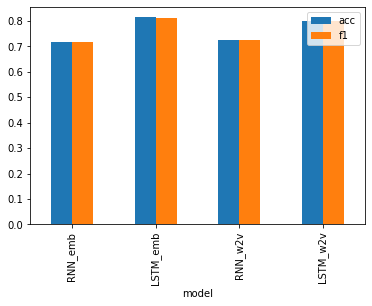

In [26]:
results = pd.read_csv('results.csv')
results.iloc[-4:].plot(kind='bar', x='model', y=['acc', 'f1'])
